In [ ]:
# import nltk 
# nltk.download('stopwords')

In [271]:
import pickle

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.metrics import silhouette_score

from stemmed_vect import StemmedCountVectorizer, StemmedTfidfVectorizer
from helper import make_silhouette_plot, print_top_words, fit_nmf

import pyLDAvis
import pyLDAvis.sklearn

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [278]:
scv = StemmedCountVectorizer(strip_accents='unicode',
                             stop_words=set(stopwords.words('english')) | set(string.punctuation),
                             max_df=0.5,
                             min_df=2,
                             ngram_range=(1, 2),
                             max_features=2000)

stv = StemmedTfidfVectorizer(strip_accents='unicode',
                             stop_words=set(stopwords.words('english')) | set(string.punctuation),
                             min_df=2,
                             max_df=0.5,
                             ngram_range=(1, 2),
                             max_features=2000)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mintleton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [249]:
# with open('scv.model', 'wb') as f:
#     pickle.dump(scv, f)

# with open('stv.model', 'wb') as f:
#     pickle.dump(stv, f)

## Import Data

In [279]:
qadf = pd.read_csv('../data/dearabby_qa.csv', index_col=0)

In [280]:
new_df = qadf[qadf['categories'].notna()]

In [281]:
# new_df = qadf[]

In [282]:
X = new_df['qa']
y = new_df['categories']


### Data Visualization

### Text length

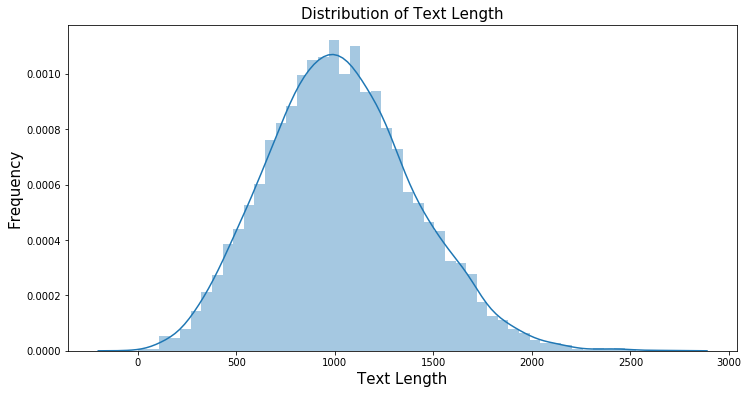

In [205]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(X.str.len())

ax.set_title('Distribution of Text Length', fontsize=15)
ax.set_xlabel('Text Length', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15);

### Mean Character Length

In [211]:
mean_char_len = X.str.split(' ').apply(lambda x: np.mean(list(map(len, x))))

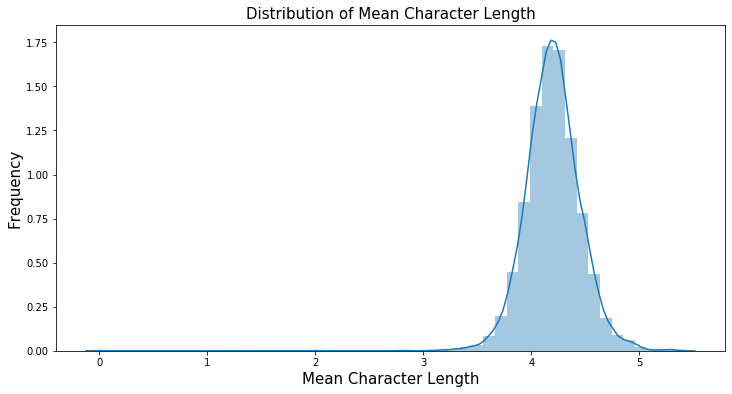

In [214]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(mean_char_len)

ax.set_title('Distribution of Mean Character Length', fontsize=15)
ax.set_xlabel('Mean Character Length', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15);

## Preprocess Text Features into DF and TFIDF

In [283]:
count_x = scv.fit_transform(X)

In [284]:
tfidf_x = stv.fit_transform(X)

## Reduce Dimension for Visualization and Clustering

In [285]:
pca_cv = PCA(n_components=2, random_state=42)
pca_x_cv = pca_cv.fit_transform(count_x.toarray())

In [286]:
pca_tv = PCA(n_components=2, random_state=42)
pca_x_tv = pca_tv.fit_transform(tfidf_x.toarray())

In [250]:
# with open('pca_cv.model', 'wb') as f:
#     pickle.dump(pca_cv, f)
    
# with open('pca_tv.model', 'wb') as f:
#     pickle.dump(pca_tv, f)

## Visualizing KMeans Clusters

### DF Clusters

2
0.3983512634579413
3
0.42413250063389785
4
0.3604097408547567
5
0.36354764879670576
6
0.3515572937055362


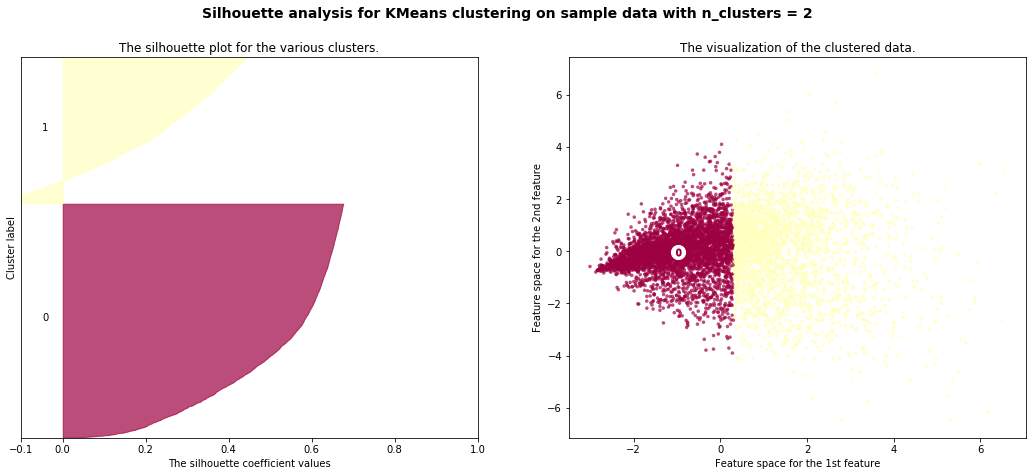

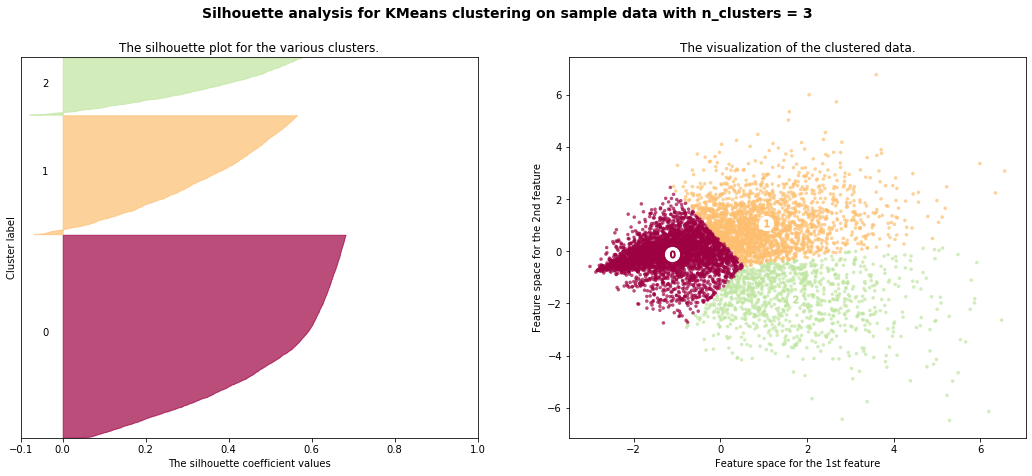

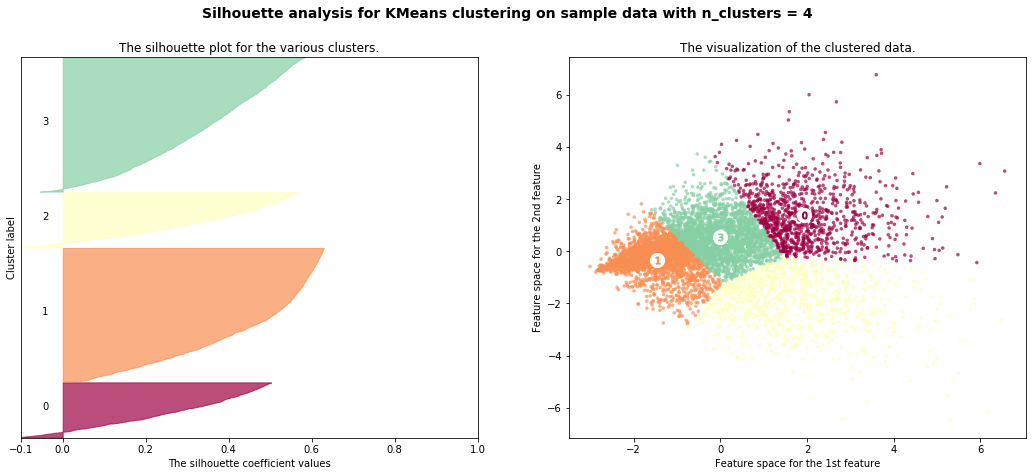

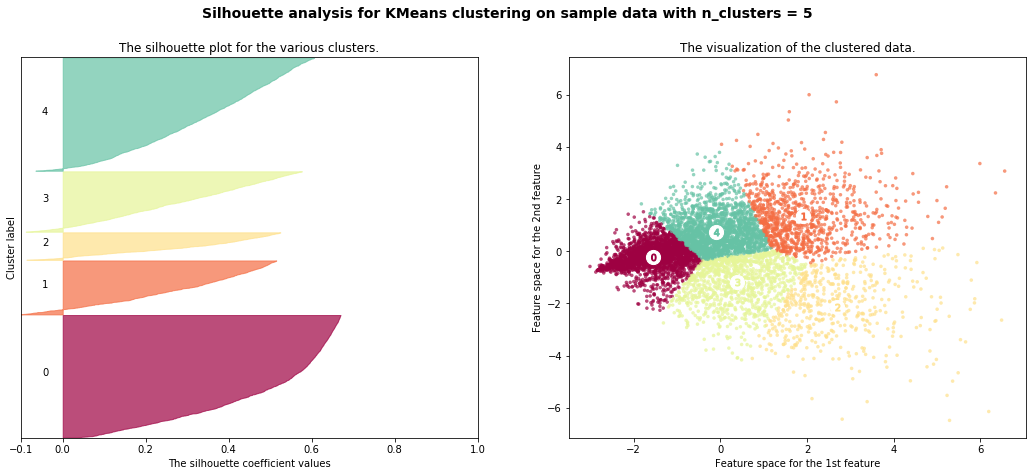

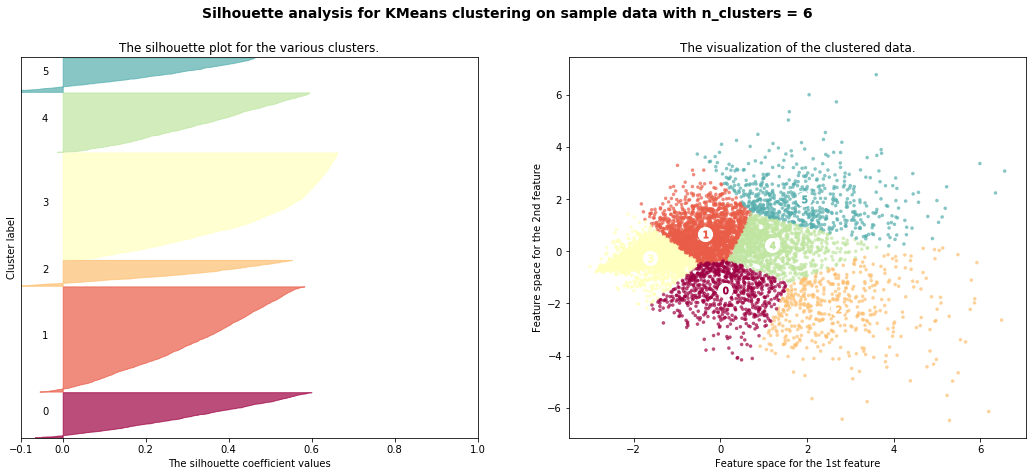

In [287]:
range_n_clusters = range(2, 7)
silhouette_scores_cv = np.empty(shape=5)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_x_cv, n_clusters=n_clusters)
    silhouette_scores_cv[idx] = score
    
    print(n_clusters)
    print(score)

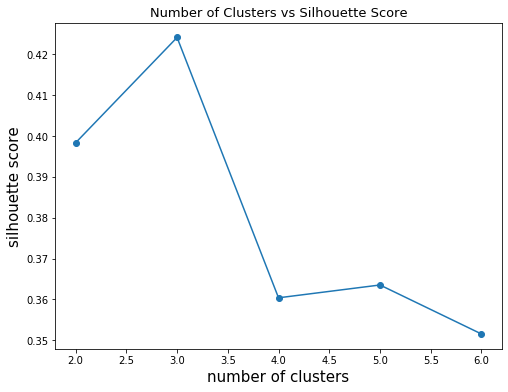

In [289]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_cv, 'o-')
ax.set_xlabel("number of clusters", fontsize=15)
ax.set_ylabel("silhouette score", fontsize=15);
ax.set_title('Number of Clusters vs Silhouette Score', fontsize=13);

### Visualizing Clusters' Words (DF)

In [290]:
nclusters = 3

In [291]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_x_cv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [292]:
original_space_centroids = pca_cv.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [293]:
terms = scv.get_feature_names()
for i in range(nclusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind], end='')
    print('\n')

Cluster 0:
 would friend think like know peopl want feel make tell year help husband famili ask person work daughter need take wife someon problem mother parent talk live call also children love pleas someth thing could home mani give gift never howev good even find told come look recent relationship tri

Cluster 1:
 want feel friend would know like year love think famili make tell relationship help live parent life need peopl mother talk thing work never children person marri daughter date wife also togeth take someon move could told problem home good find start much school even boyfriend father call someth come

Cluster 2:
 husband want year famili would feel know marri children mother help live love daughter marriag think need make tell home like wife work take father life sister never child parent told talk problem could thing say move come also togeth relationship kid tri stay hous visit ask month much care



In [294]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_x_cv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.427



### Comparing Topics To Top 5 Categories in the Clusters

In [295]:
llabels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

mlb = MultiLabelBinarizer()

for i in range(nclusters):
    pred = llabels.loc[llabels[0] == i, 'categories'].fillna('list()').apply(eval)

    res = pd.DataFrame(mlb.fit_transform(pred),
                       columns=mlb.classes_,
                       index=pred.index)

    print(f'topic {i}:')
    print(f'{res.sum(axis=0).sort_values(ascending=False)[:5]}')
    print()

topic 0:
Family & Parenting    1238
Etiquette & Ethics    1087
Health & Safety        571
Love & Dating          524
Marriage & Divorce     509
dtype: int64

topic 1:
Family & Parenting     957
Love & Dating          701
Friends & Neighbors    440
Marriage & Divorce     414
Teens                  261
dtype: int64

topic 2:
Marriage & Divorce    593
Family & Parenting    535
Money                 160
Health & Safety       135
Sex & Gender          104
dtype: int64



### TFIDF Clusters

2
0.3406389539374284
3
0.3573288907864832
4
0.34776656330555217
5
0.35093469464613314
6
0.3485519476581309


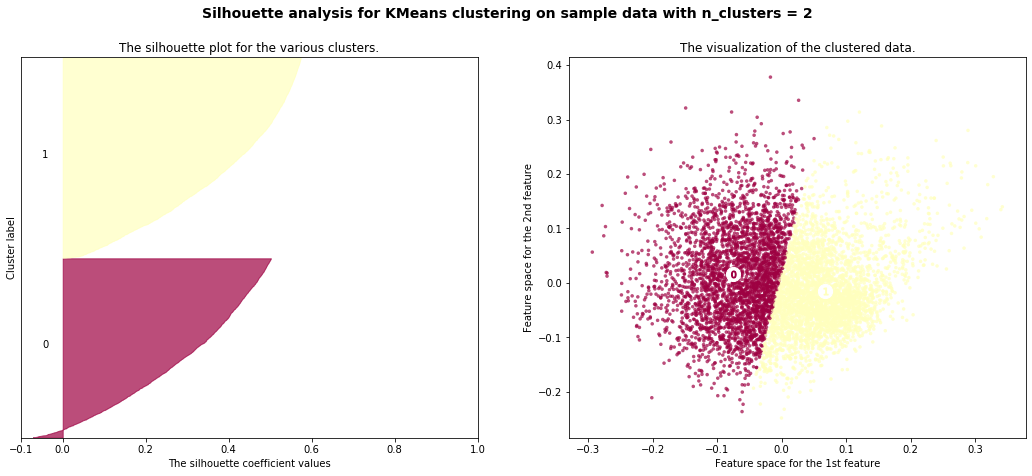

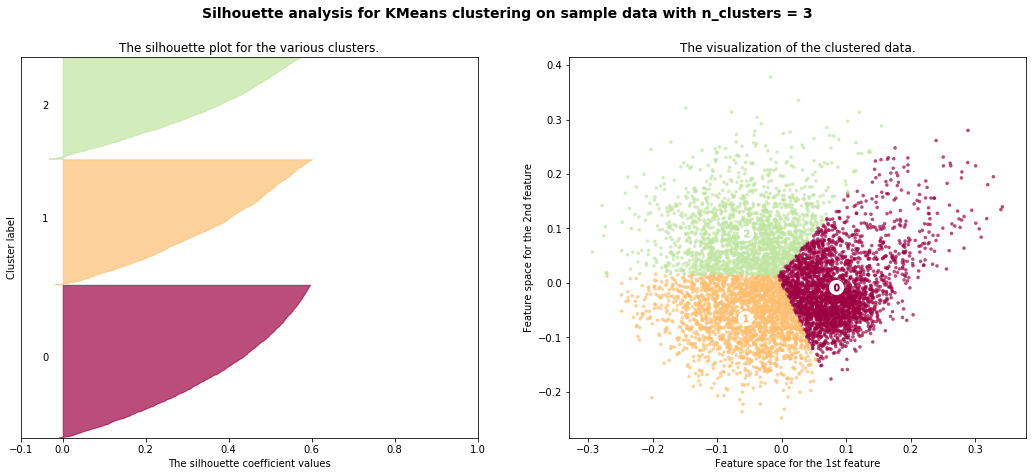

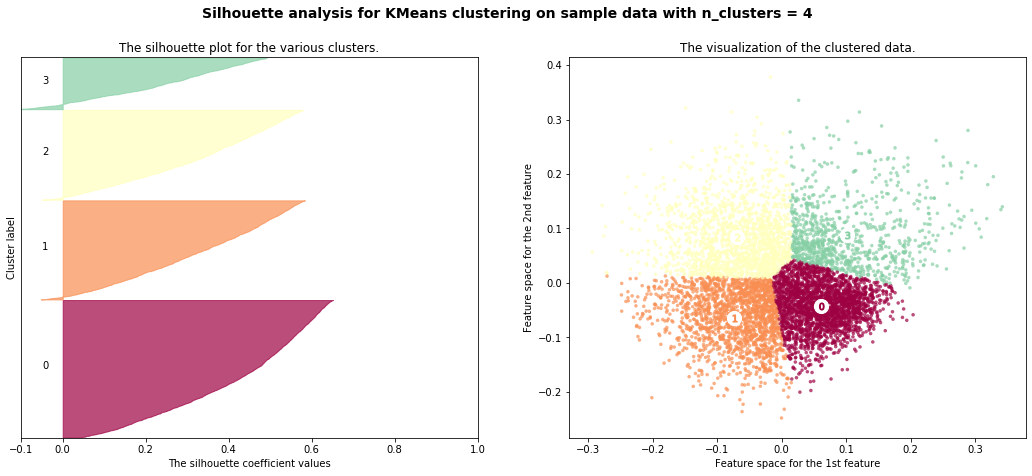

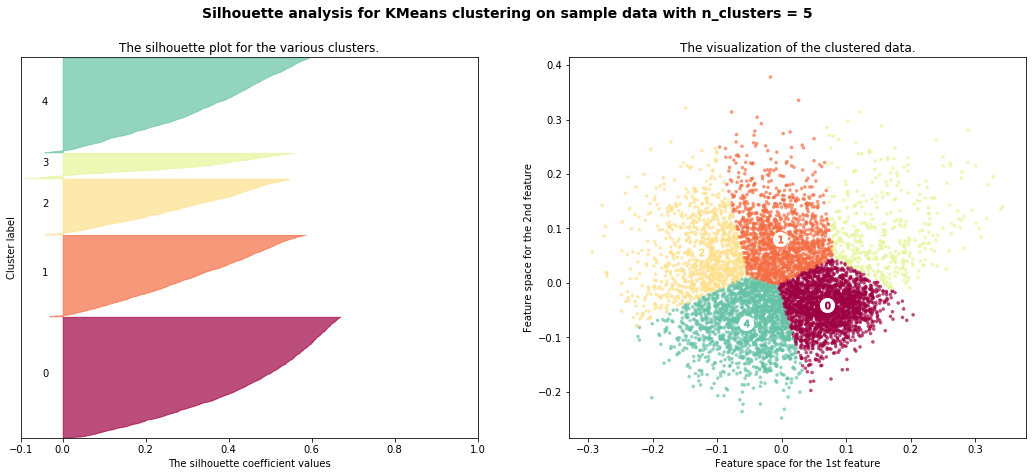

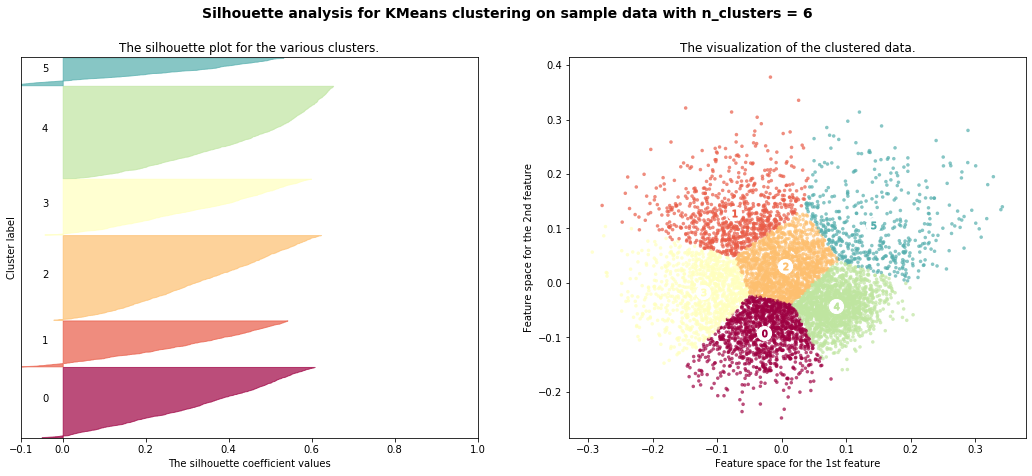

In [296]:
range_n_clusters = range(2, 7)
silhouette_scores_tv = np.empty(shape=5)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_x_tv, n_clusters=n_clusters)
    silhouette_scores_tv[idx] = score
    
    print(n_clusters)
    print(score)

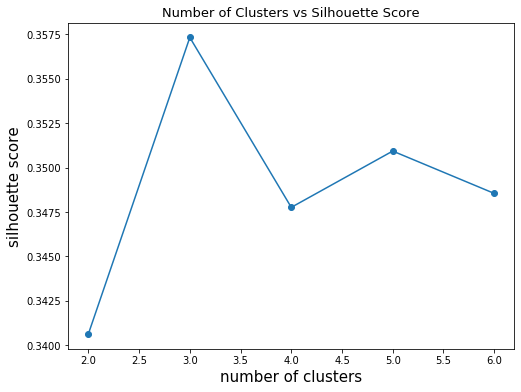

In [297]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_tv, 'o-')
ax.set_xlabel("number of clusters", fontsize=15)
ax.set_ylabel("silhouette score", fontsize=15);
ax.set_title('Number of Clusters vs Silhouette Score', fontsize=13);

### Visualizing Clusters' Words (TFIDF)

In [298]:
nclusters = 3

In [299]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_x_tv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [300]:
original_space_centroids = pca_tv.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [301]:
terms = stv.get_feature_names()
for i in range(nclusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind], end='')
    print('\n')

Cluster 0:
 friend gift would peopl like think invit person know feel want ask make wed famili tell someon thank work take parent call help someth mani daughter give home parti need pleas also look could rude good problem school howev money come thing even food card husband dinner send birthday guest

Cluster 1:
 friend want feel year love know relationship husband like would tell help think date talk make life work marri wife marriag need peopl boyfriend live togeth thing never someon move problem person find start woman say good told call famili month much could still look school back take tri someth

Cluster 2:
 husband daughter mother famili children want parent year would father sister live wife feel child marri know love help think tell marriag home need brother make like kid babi life move relationship take told never wed divorc come thing work talk hous gift togeth visit care stay also could give



In [302]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_x_tv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.351



### Comparing Topics To Top 5 Categories in the Clusters

In [303]:
llabels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

mlb = MultiLabelBinarizer()

for i in range(nclusters):
    pred = llabels.loc[llabels[0] == i, 'categories'].fillna('list()').apply(eval)

    res = pd.DataFrame(mlb.fit_transform(pred),
                       columns=mlb.classes_,
                       index=pred.index)

    print(f'topic {i}:')
    print(f'{res.sum(axis=0).sort_values(ascending=False)[:5]}')
    print()

topic 0:
Etiquette & Ethics     1090
Family & Parenting      769
Friends & Neighbors     512
Health & Safety         468
Money                   412
dtype: int64

topic 1:
Love & Dating          906
Marriage & Divorce     708
Family & Parenting     487
Friends & Neighbors    408
Sex & Gender           319
dtype: int64

topic 2:
Family & Parenting         1474
Marriage & Divorce          544
Money                       261
Health & Safety             213
Holidays & Celebrations     194
dtype: int64



## NMF and LDA Clustering

### NMF Visualization

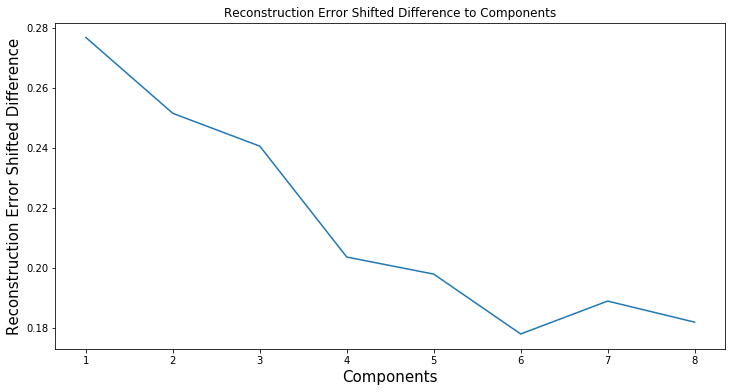

In [329]:
# Compute NMF
nrange = range(1, 10)
error = [fit_nmf(i, tfidf_x) for i in nrange]

fig, ax = plt.subplots(figsize=(12, 6))

# ax.plot(nrange, error)
a = np.array(error)
b = a[1:]


ax.plot(range(1, 9), a[:-1] - b)
ax.set_title('Reconstruction Error Shifted Difference to Components')
ax.set_xlabel('Components', fontsize=15)
ax.set_ylabel('Reconstruction Error Shifted Difference', fontsize=15);

In [305]:
n_components= 4
n_top_words = 50

In [306]:
nmf = NMF(n_components=n_components, random_state=42,).fit(tfidf_x)

tfidf_feature_names = stv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: daughter mother parent children famili father child sister live babi brother kid want home help girl would know care visit adult take need move tell hous school sibl feel rais come also make respons think support told abus life allow away adopt stay young littl like older could thing keep

Topic #1: gift wed invit parti birthday card would guest thank send attend friend famili dinner receiv celebr give shower note christma money coupl host ask bride holiday etiquett food plan rude sister sent expect daughter fianc peopl think includ bring nice return thought like gave present item engag event someth appropri

Topic #2: friend feel like peopl know want date relationship person think would tell make someon talk work boyfriend help love thing find call life need look start problem good school year someth mani ask woman never even much seem could togeth pleas realli back stop women go tri also take keep

Topic #3: husband wife marriag marri year love divorc want togeth feel famil

In [242]:
n_components= 4
n_top_words = 50

In [243]:
lda_cv = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda_tf = lda_cv.fit_transform(count_x)
tf_feature_names = scv.get_feature_names()
print_top_words(lda_cv, tf_feature_names, n_top_words)

Topic #0: help parent school need know children want feel work talk child make like problem daughter take abus also would girl peopl find think tell live life high doctor start pleas colleg mother health go care could year support becom tri thing get famili medic stop someth adult keep right happen

Topic #1: peopl would think like person ask work make look call thank gift someon want know tell wear someth friend mani phone feel busi neighbor rude send pleas worker could good also dress woman letter howev reader said receiv problem walk convers keep embarrass take birthday question use husband talk suggest

Topic #2: husband home would famili want invit hous live friend take feel daughter money make like visit wed dinner wife think come mother work food need stay parti ask year help plan spend room even gift children guest know enjoy give week attend move retir coupl problem everi much leav could

Topic #3: year want feel friend would know husband love relationship famili like marri te

### pyLDAvis 

In [88]:
pyLDAvis.enable_notebook()

In [245]:
p = pyLDAvis.sklearn.prepare(lda_cv, count_x, scv)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.039935  0.003671       1        1  42.503192
0     -0.102037 -0.068222       2        1  22.189684
2      0.006345  0.120431       3        1  18.759869
1      0.135627 -0.055880       4        1  16.547255, topic_info=              Term         Freq        Total Category  logprob  loglift
1553        school  1176.000000  1176.000000  Default  30.0000  30.0000
880           home  1838.000000  1838.000000  Default  29.0000  29.0000
1467  relationship  2010.000000  2010.000000  Default  28.0000  28.0000
977          invit   946.000000   946.000000  Default  27.0000  27.0000
868           help  2905.000000  2905.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
754         friend   411.203034  3769.218777   Topic4  -5.2066  -0.4166
693           feel   329.050851  4392.868391   Topic4  -5.4295  -0.7926
1325         pleas   294.160480  1446.549400   Topic4  -5.5416   0.2061
415          could   287.262955  1653.947131   Topic4  -5.5653   0.0484
794           good   284.486232  1414.354135   Topic4  -5.5750   0.1952

[342 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5         1  0.070767    abus
5         2  0.928598    abus
27        1  0.015634  addict
27        2  0.979757  addict
33        1  0.934885   adopt
...     ...       ...     ...
1983      4  0.163696   would
1992      1  0.770065    year
1992      2  0.107782    year
1992      3  0.104019    year
1992      4  0.018277    year

[726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [258]:
# pyLDAvis.save_html(p, 'lda.html')